<a href="https://colab.research.google.com/github/RiceWater/New-Thesis-KFold-2CLS/blob/Only-Building/Kaggle_2CLS_Only_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arrow                            1.3.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
b

In [9]:
!pip uninstall jax -y

In [10]:
!pip install tensorflow==2.15.0

In [11]:
!python --version

Python 3.10.12


In [12]:
!pip install image_to_numpy==1.0.0

In [13]:
!pip install neptune==1.9.1 neptune-tensorflow-keras==2.2.2

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

In [17]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset'):
    print(os.path.join(dirname))




/content/drive/MyDrive/Chua_Thesis/4-600-Dataset
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Road
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Vehicle
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Plant
/content/drive/MyDrive/Chua_Thesis/4-600-Dataset/Building


In [47]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=32, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=640,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))

    model.add(Dense(units=2, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [48]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter),
                                                                 monitor='val_loss',
                                                                 mode='auto',
                                                                 save_best_only=True,
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                         factor=0.6,
                                                         patience=10,
                                                         min_delta=0.001,
                                                         mode='auto',
                                                         verbose=1)
#     return [reduce_lr, cp_callback, es_callback]
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [20]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

In [21]:
with tf.device('/gpu:0'):
    labels = ['Building', 'Road']
    X_train = []
    y_train = []
    y_label_idx = []
    image_size = 256
    for i in labels:
        folderPath = os.path.join('/content/drive/MyDrive/Chua_Thesis/4-600-Dataset', i)
        for j in os.listdir(folderPath):
            img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_label_idx.append(labels.index(i))

In [22]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [23]:
# seed ensures that the generation are the same from local and kaggle
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, roads_test_idx), axis=None)
print(total_test_idx[:20])

[273 397 467 471 105 584 208 456  32 573 462 540 261 134 460 229 494 293
 412 515]


In [24]:
def train_test_X(X_train_scaled):
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [25]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

## KFOLD

In [26]:
!mkdir MODEL

In [27]:
!ls ./

drive  MODEL  sample_data


In [49]:
model_name= 'Model 2CLS-OB-4.1.2'
checkpoint_path = f'/content/MODEL/{model_name}/FOLD-'
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)
project_name='New-Thesis/Kaggle-2Cls-Only-Building'

[neptune] [info   ] Neptune initialized. Open in the app: offline/0c12b94c-5a36-493b-8707-84a21ecbc19a
Epoch 1/45
  5/105 [>.............................] - ETA: 4s - loss: 93.2161 - accuracy: 0.5250

105/105 [==============================] - ETA: 0s - loss: 22.5429 - accuracy: 0.7357
Epoch 1: val_loss improved from inf to 32.33735, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-0
105/105 [==============================] - 16s 102ms/step - loss: 22.5429 - accuracy: 0.7357 - val_loss: 32.3374 - val_accuracy: 0.5333 - lr: 0.0015
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 4.0871 - accuracy: 0.8393
Epoch 2: val_loss improved from 32.33735 to 9.94622, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-0
105/105 [==============================] - 9s 85ms/step - loss: 4.0871 - accuracy: 0.8393 - val_loss: 9.9462 - val_accuracy: 0.6333 - lr: 0.0015
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 3.7101 - accuracy: 0.8143
Epoch 3: val_loss did not improve from 9.94622
105/105 [==============================] - 5s 48ms/step - loss: 3.7101 - accuracy: 0.8143 - val_loss: 27.1118 - val_accuracy: 0.5000 - lr: 0.0015
Epoch 4/45
105/10

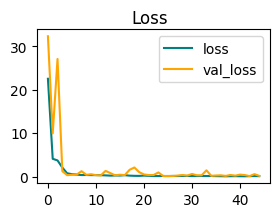

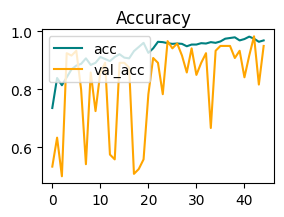

Fold Training Time: 0 hour(s) and 4 mins
Precision: 98.33333492279053  -  Recall: 98.33333492279053
Accuracy: 98.33333492279053
F1Score-B: 98.30508422851562
F1Score-R: 98.36064910888672
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/646cc76d-1cfc-46ae-9e11-a315ddf59dcd
Epoch 1/45
  5/105 [>.............................] - ETA: 4s - loss: 110.2988 - accuracy: 0.6500

104/105 [============================>.] - ETA: 0s - loss: 25.0377 - accuracy: 0.7692
Epoch 1: val_loss improved from inf to 55.14406, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-1
105/105 [==============================] - 13s 87ms/step - loss: 24.8398 - accuracy: 0.7702 - val_loss: 55.1441 - val_accuracy: 0.5000 - lr: 0.0015
Epoch 2/45
104/105 [============================>.] - ETA: 0s - loss: 5.7360 - accuracy: 0.8029
Epoch 2: val_loss improved from 55.14406 to 12.53187, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-1
105/105 [==============================] - 9s 85ms/step - loss: 5.7060 - accuracy: 0.8012 - val_loss: 12.5319 - val_accuracy: 0.5667 - lr: 0.0015
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 1.6388 - accuracy: 0.8524
Epoch 3: val_loss improved from 12.53187 to 0.95938, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-1
105/105 [==============================] - 11s 107ms/step - loss: 1.6388 - accuracy: 0.8524 - val_

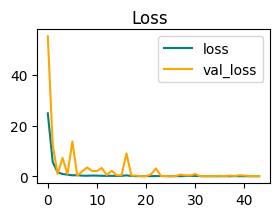

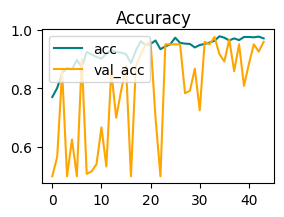

Fold Training Time: 0 hour(s) and 4 mins
Precision: 95.83333134651184  -  Recall: 95.83333134651184
Accuracy: 95.83333134651184
F1Score-B: 95.86776733398438
F1Score-R: 95.7983169555664
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/7720d535-929d-41ca-bd61-765fd0853faf
Epoch 1/45
  5/105 [>.............................] - ETA: 4s - loss: 143.5414 - accuracy: 0.5750

104/105 [============================>.] - ETA: 0s - loss: 32.8339 - accuracy: 0.7873
Epoch 1: val_loss improved from inf to 30.05589, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-2
105/105 [==============================] - 13s 87ms/step - loss: 32.5561 - accuracy: 0.7881 - val_loss: 30.0559 - val_accuracy: 0.5333 - lr: 0.0015
Epoch 2/45
104/105 [============================>.] - ETA: 0s - loss: 3.6080 - accuracy: 0.8606
Epoch 2: val_loss improved from 30.05589 to 9.97358, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-2
105/105 [==============================] - 9s 85ms/step - loss: 3.6279 - accuracy: 0.8607 - val_loss: 9.9736 - val_accuracy: 0.6333 - lr: 0.0015
Epoch 3/45
104/105 [============================>.] - ETA: 0s - loss: 1.4313 - accuracy: 0.8714
Epoch 3: val_loss improved from 9.97358 to 2.52857, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-2
105/105 [==============================] - 10s 92ms/step - loss: 1.4264 - accuracy: 0.8714 - val_loss

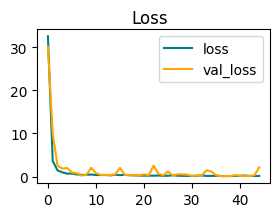

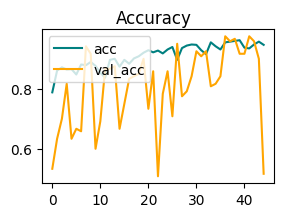

Fold Training Time: 0 hour(s) and 4 mins
Precision: 97.50000238418579  -  Recall: 97.50000238418579
Accuracy: 97.50000238418579
F1Score-B: 97.4358901977539
F1Score-R: 97.56097412109375
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/f6103709-f572-44fc-98d1-26793e9a703b
Epoch 1/45
  5/105 [>.............................] - ETA: 4s - loss: 110.1508 - accuracy: 0.5750

105/105 [==============================] - ETA: 0s - loss: 29.7309 - accuracy: 0.7774
Epoch 1: val_loss improved from inf to 13.48104, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-3
105/105 [==============================] - 13s 87ms/step - loss: 29.7309 - accuracy: 0.7774 - val_loss: 13.4810 - val_accuracy: 0.6000 - lr: 0.0015
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 4.2908 - accuracy: 0.8381
Epoch 2: val_loss improved from 13.48104 to 1.89434, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-3
105/105 [==============================] - 9s 85ms/step - loss: 4.2908 - accuracy: 0.8381 - val_loss: 1.8943 - val_accuracy: 0.7917 - lr: 0.0015
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 2.1310 - accuracy: 0.8190
Epoch 3: val_loss improved from 1.89434 to 0.63917, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-3
105/105 [==============================] - 10s 95ms/step - loss: 2.1310 - accuracy: 0.8190 - val_loss

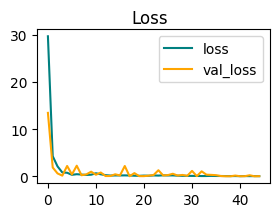

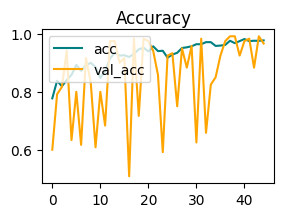

Fold Training Time: 0 hour(s) and 4 mins
Precision: 99.16666746139526  -  Recall: 99.16666746139526
Accuracy: 99.16666746139526
F1Score-B: 99.15966033935547
F1Score-R: 99.17355346679688
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/3d8265b4-bf7a-4482-ab05-427c4fb7c137
Epoch 1/45
  5/105 [>.............................] - ETA: 4s - loss: 153.2702 - accuracy: 0.4750

105/105 [==============================] - ETA: 0s - loss: 25.5149 - accuracy: 0.7429
Epoch 1: val_loss improved from inf to 9.85543, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-4
105/105 [==============================] - 13s 92ms/step - loss: 25.5149 - accuracy: 0.7429 - val_loss: 9.8554 - val_accuracy: 0.5083 - lr: 0.0015
Epoch 2/45
104/105 [============================>.] - ETA: 0s - loss: 5.1407 - accuracy: 0.8041
Epoch 2: val_loss improved from 9.85543 to 1.89029, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-4
105/105 [==============================] - 9s 85ms/step - loss: 5.1717 - accuracy: 0.8012 - val_loss: 1.8903 - val_accuracy: 0.6333 - lr: 0.0015
Epoch 3/45
104/105 [============================>.] - ETA: 0s - loss: 2.4302 - accuracy: 0.8293
Epoch 3: val_loss improved from 1.89029 to 1.86328, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-4
105/105 [==============================] - 9s 85ms/step - loss: 2.4071 - accuracy: 0.8310 - val_loss: 1.

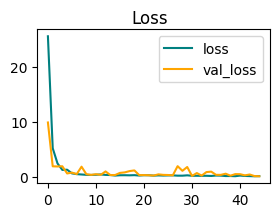

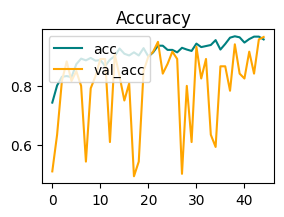

Fold Training Time: 0 hour(s) and 4 mins
Precision: 96.66666388511658  -  Recall: 96.66666388511658
Accuracy: 96.66666388511658
F1Score-B: 96.61016845703125
F1Score-R: 96.72130584716797
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/f6c14a20-9858-47d6-ae7e-50ada4848fe4
Epoch 1/45
  5/105 [>.............................] - ETA: 4s - loss: 76.5205 - accuracy: 0.6750

105/105 [==============================] - ETA: 0s - loss: 33.5507 - accuracy: 0.7560
Epoch 1: val_loss improved from inf to 5.15992, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-5
105/105 [==============================] - 13s 92ms/step - loss: 33.5507 - accuracy: 0.7560 - val_loss: 5.1599 - val_accuracy: 0.8500 - lr: 0.0015
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 4.7531 - accuracy: 0.8262
Epoch 2: val_loss did not improve from 5.15992
105/105 [==============================] - 5s 48ms/step - loss: 4.7531 - accuracy: 0.8262 - val_loss: 13.7235 - val_accuracy: 0.5083 - lr: 0.0015
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 2.0350 - accuracy: 0.8405
Epoch 3: val_loss improved from 5.15992 to 2.90264, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-5
105/105 [==============================] - 9s 85ms/step - loss: 2.0350 - accuracy: 0.8405 - val_loss: 2.9026 - val_accuracy: 0.6083 - lr: 0.0015
Epoch 4/45
105/105 [=

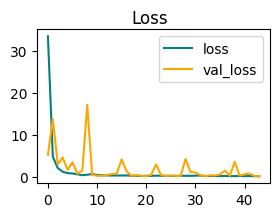

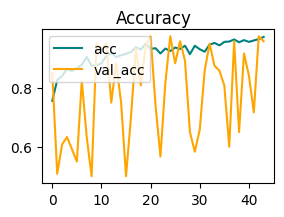

Fold Training Time: 0 hour(s) and 4 mins
Precision: 97.50000238418579  -  Recall: 97.50000238418579
Accuracy: 97.50000238418579
F1Score-B: 97.47898864746094
F1Score-R: 97.52066040039062
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/bf6ab5ce-2258-4f49-8a37-19757fab37cf
Epoch 1/45
  5/105 [>.............................] - ETA: 4s - loss: 114.9377 - accuracy: 0.5250

105/105 [==============================] - ETA: 0s - loss: 33.7978 - accuracy: 0.7452
Epoch 1: val_loss improved from inf to 19.31907, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-6
105/105 [==============================] - 12s 86ms/step - loss: 33.7978 - accuracy: 0.7452 - val_loss: 19.3191 - val_accuracy: 0.6250 - lr: 0.0015
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 4.3981 - accuracy: 0.8357
Epoch 2: val_loss improved from 19.31907 to 0.27732, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-6
105/105 [==============================] - 9s 85ms/step - loss: 4.3981 - accuracy: 0.8357 - val_loss: 0.2773 - val_accuracy: 0.9667 - lr: 0.0015
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 1.3140 - accuracy: 0.8452
Epoch 3: val_loss did not improve from 0.27732
105/105 [==============================] - 5s 48ms/step - loss: 1.3140 - accuracy: 0.8452 - val_loss: 0.6750 - val_accuracy: 0.7667 - lr: 0.0015
Epoch 4/45
105/105 

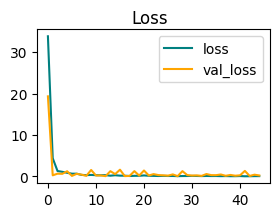

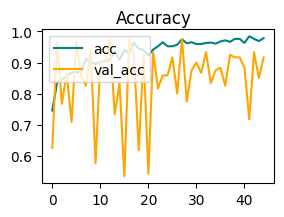

Fold Training Time: 0 hour(s) and 4 mins
Precision: 97.50000238418579  -  Recall: 97.50000238418579
Accuracy: 97.50000238418579
F1Score-B: 97.52066040039062
F1Score-R: 97.47898864746094
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/28380694-04c3-43ac-9ba5-3de61c132361
Epoch 1/45
  5/105 [>.............................] - ETA: 4s - loss: 140.5684 - accuracy: 0.5000

105/105 [==============================] - ETA: 0s - loss: 24.7061 - accuracy: 0.7262
Epoch 1: val_loss improved from inf to 13.12797, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-7
105/105 [==============================] - 12s 86ms/step - loss: 24.7061 - accuracy: 0.7262 - val_loss: 13.1280 - val_accuracy: 0.6917 - lr: 0.0015
Epoch 2/45
105/105 [==============================] - ETA: 0s - loss: 4.9532 - accuracy: 0.7893
Epoch 2: val_loss improved from 13.12797 to 1.11119, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-7
105/105 [==============================] - 11s 109ms/step - loss: 4.9532 - accuracy: 0.7893 - val_loss: 1.1112 - val_accuracy: 0.7917 - lr: 0.0015
Epoch 3/45
105/105 [==============================] - ETA: 0s - loss: 2.2191 - accuracy: 0.8214
Epoch 3: val_loss improved from 1.11119 to 0.49552, saving model to /content/MODEL/Model 2CLS-OB-4.1.2/FOLD-7
105/105 [==============================] - 9s 86ms/step - loss: 2.2191 - accuracy: 0.8214 - val_los

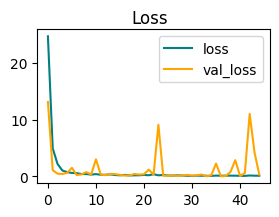

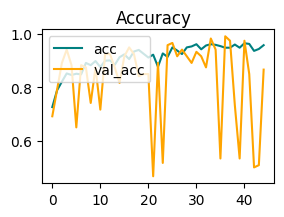

Fold Training Time: 0 hour(s) and 4 mins
Precision: 99.16666746139526  -  Recall: 99.16666746139526
Accuracy: 99.16666746139526
F1Score-B: 99.17355346679688
F1Score-R: 99.15966033935547
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 0 hour(s) and 36 mins


In [50]:
params = {
    "lr": 0.0015,
    "epochs": 45,
    "batch_size": 8}

precisions = []
recalls = []
accuracies = []
f1_bld = []
f1_road = []

with tf.device('/gpu:0'):
    counter = 0
    start = perf_counter()
    for train, test in kfold.split(train_x, train_y):
        start_fold = perf_counter()

        run = neptune.init_run(
            name= f"{model_name}-FOLD_{counter}",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )  # your credentials

        run["parameters"] = params


        model = make_model(params)
        cat_y = tf.keras.utils.to_categorical(train_y)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
        train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])

        test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
        test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])

        hist = model.fit(train_fold,
                         validation_data=test_fold,
                         batch_size=params['batch_size'],
                         epochs=params['epochs'],
                         verbose=1,
                         callbacks=create_callbacks(counter))
        end_fold = perf_counter()

        # PLOTTING ==================================================
        run["fig-train_loss"].upload(plot_loss(hist))
        run["fig-train_acc"].upload(plot_acc(hist))

        # EVALUATING ==================================================
        model = tf.keras.models.load_model(checkpoint_path + str(counter))

        pre = Precision()
        rec = Recall()
        c_acc = CategoricalAccuracy()
        f1_score = F1Score()
        for batch in test_fold.as_numpy_iterator():
            X, y = batch
            yhat = model.predict(X, verbose=0)
            pre.update_state(y, yhat)
            rec.update_state(y, yhat)
            c_acc.update_state(y, yhat)
            f1_score.update_state(y, yhat)


        precisions.append(pre.result().numpy() * 100)
        recalls.append(rec.result().numpy() * 100)
        accuracies.append(c_acc.result().numpy() * 100)
        f1_s = f1_score.result().numpy() * 100

        f1_bld.append(f1_s[0])
        f1_road.append(f1_s[1])

        run["eval/ACC/"] = accuracies[counter]
        run["eval/REC/"] = recalls[counter]
        run["eval/PRE/"] = precisions[counter]
        run["eval/F1-B"] = f1_bld[counter]
        run["eval/F1-R"] = f1_road[counter]

        # SAVE MODEL TO NEPTUNE AI =======================================
        model_save_path = f'{checkpoint_path}{counter}/{model_name}-FOLD-{counter}.keras'
        model.save(model_save_path)
        run['checkpoint/model'].upload(model_save_path)

        # PRINTING RESULTS ===========================================
        print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
        print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
        print(f'Accuracy: {accuracies[counter]}')
        print(f'F1Score-B: {f1_bld[counter]}')
        print(f'F1Score-R: {f1_road[counter]}')

        run.stop()

        counter += 1

    end = perf_counter()
    print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [51]:
print(f"""
Avg Accuracy: {avg_rate(accuracies)}
Avg Precision: {avg_rate(precisions)}
Avg Recall: {avg_rate(recalls)}
Avg F1-Score-B: {avg_rate(f1_bld)}
Avg F1-Score-R: {avg_rate(f1_road)}
""")


Avg Accuracy: 97.70833402872086
Avg Precision: 97.70833402872086
Avg Recall: 97.70833402872086
Avg F1-Score-B: 97.69397163391113
Avg F1-Score-R: 97.72176361083984



In [52]:
run = neptune.init_run(
            name= f"{model_name}-AVG",
            project=project_name,
            mode="offline",     # To prevent issue when internet sucks. Just manually sync it
            )

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-B"] = avg_rate(f1_bld)
run["eval/F1-R"] = avg_rate(f1_road)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/a8a82697-8661-4b11-9379-94ec5c663f22
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


In [54]:
os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiM2YzNGEwOC1iNmYyLTQ3YTEtYTljNi0xOWNmYWE0ZjZjOTMifQ=="

In [55]:
!neptune sync -p 'New-Thesis/Kaggle-2Cls-Only-Building' --offline-only


Offline container 9bd76622-6ff3-4f50-b92e-ce60869f1295 registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-19
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-19
Deleted: /content/.neptune/async/run__9bd76622-6ff3-4f50-b92e-ce60869f1295__93830__6wonq4ap
Synchronization of run New-Thesis/Kaggle-2Cls-Only-Building/K2OB-19 completed.
Offline container 9bd76653-cc16-4dcb-b114-9dd5117682f9 registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-20
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-20
Deleted: /content/.neptune/async/run__9bd76653-cc16-4dcb-b114-9dd5117682f9__93830__ovbu6bxy
Synchronization of run New-Thesis/Kaggle-2Cls-Only-Building/K2OB-20 completed.
Offline container 9bd7667f-4740-48f5-8ec7-4c8f350903ea registered as New-Thesis/Kaggle-2Cls-Only-Building/K2OB-21
Synchronising New-Thesis/Kaggle-2Cls-Only-Building/K2OB-21
Deleted: /content/.neptune/async/run__9bd7667f-4740-48f5-8ec7-4c8f350903ea__93830__am3jqfed
Synchronization of run New-Thesis/Kaggle-2Cls-O

In [56]:
!neptune clear


In [57]:
!rm -r "/content/MODEL/Model 2CLS-OB-4.1.2"